# Task 2


# Task 2.1

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple

np.random.seed(11) #seed

## 1. Generación de Datos

### 1.a
Vamos a generar 1000 puntos basados en la función: $y = 2x^3 - 3x^2 + 5x + 3$

### 1.b
Luego agregaremos ruido gaussiano y normalizaremos los datos.

In [2]:
def generate_polynomial_data(n_samples: int = 1000, noise_std: float = 0.5) -> Tuple[np.ndarray, np.ndarray]:
    # Generar valores de x en el rango [-2, 2]
    X = np.random.uniform(-2, 2, n_samples)
    
    # Calcular y usando la función polinomial: y = 2x³ - 3x² + 5x + 3
    y_true = 2 * X**3 - 3 * X**2 + 5 * X + 3
    
    # Agregar ruido aleatorio normal (gaussiano)
    noise = np.random.normal(0, noise_std, n_samples)
    y = y_true + noise
    
    return X, y

# Generar los datos
X_raw, y_raw = generate_polynomial_data(n_samples=1000, noise_std=2.0)

print(f"Datos generados:")
print(f"    Número de muestras: {len(X_raw)}")
print(f"    Rango de X: [{X_raw.min():.2f}, {X_raw.max():.2f}]")
print(f"    Rango de y: [{y_raw.min():.2f}, {y_raw.max():.2f}]")

Datos generados:
    Número de muestras: 1000
    Rango de X: [-1.99, 1.99]
    Rango de y: [-35.49, 19.04]


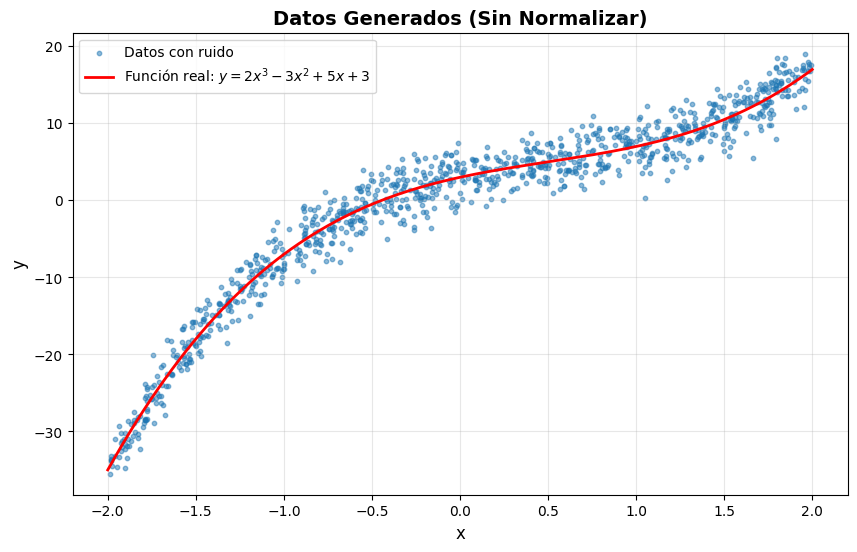

In [3]:
# Visualizar los datos generados
plt.figure(figsize=(10, 6))
plt.scatter(X_raw, y_raw, alpha=0.5, s=10, label='Datos con ruido')

# Graficar la función verdadera
X_true = np.linspace(-2, 2, 200)
y_true = 2 * X_true**3 - 3 * X_true**2 + 5 * X_true + 3
plt.plot(X_true, y_true, 'r-', linewidth=2, label='Función real: $y = 2x^3 - 3x^2 + 5x + 3$')

plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title('Datos Generados (Sin Normalizar)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### 1.c. Normalizacion de los datos
Usaremos Z-score normalization: $z = \frac{x - \mu}{\sigma}$

donde $\mu$ es la media y $\sigma$ es la desviación estándar.

In [4]:
def normalize_data(X: np.ndarray, y: np.ndarray) -> Tuple[np.ndarray, np.ndarray, dict]:
    # Calcular media y desviación estándar
    X_mean = np.mean(X)
    X_std = np.std(X)
    y_mean = np.mean(y)
    y_std = np.std(y)
    
    # Normalizar
    X_norm = (X - X_mean) / X_std
    y_norm = (y - y_mean) / y_std
    
    # Guardar estadísticas para desnormalizar después si es necesario
    stats = {
        'X_mean': X_mean,
        'X_std': X_std,
        'y_mean': y_mean,
        'y_std': y_std
    }
    
    return X_norm, y_norm, stats

# Normalizar los datos
X_norm, y_norm, normalization_stats = normalize_data(X_raw, y_raw)

print("Datos normalizados:")
print(f"    X normalizado: media = {X_norm.mean():.6f}, std = {X_norm.std():.6f}")
print(f"    y normalizado: media = {y_norm.mean():.6f}, std = {y_norm.std():.6f}")
print(f"\nEstadísticas de normalización:")
for key, value in normalization_stats.items():
    print(f"    {key}: {value:.4f}")

Datos normalizados:
    X normalizado: media = 0.000000, std = 1.000000
    y normalizado: media = -0.000000, std = 1.000000

Estadísticas de normalización:
    X_mean: 0.0300
    X_std: 1.1466
    y_mean: -0.5162
    y_std: 11.9496


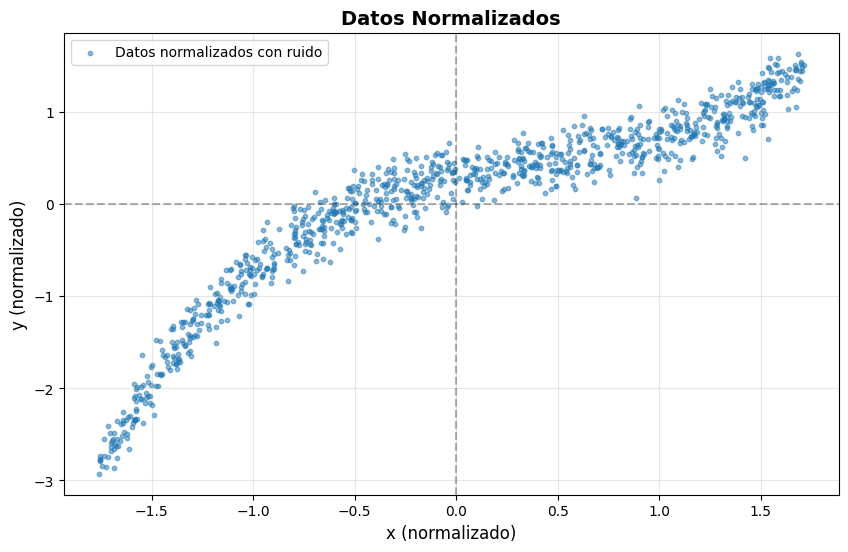

In [5]:
# Visualizar datos normalizados
plt.figure(figsize=(10, 6))
plt.scatter(X_norm, y_norm, alpha=0.5, s=10, label='Datos normalizados con ruido')
plt.xlabel('x (normalizado)', fontsize=12)
plt.ylabel('y (normalizado)', fontsize=12)
plt.title('Datos Normalizados', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='--', alpha=0.3)
plt.show()

## 2. Implementacion de Algoritmos

### Algoritmos de Descenso de Gradiente

Modelo polinomial: $\hat{y} = w_0 + w_1 x + w_2 x^2 + w_3 x^3$

Función de pérdida (MSE): $L(w) = \frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2$

Gradiente: $\nabla L = \frac{\partial L}{\partial w}$

#### Funciones Auxiliares
Funciones para calcular predicciones, pérdida y gradientes.

In [6]:
def create_polynomial_features(X: np.ndarray, degree: int = 3) -> np.ndarray: #Crea matriz de features polinomiales
    n_samples = len(X)
    X_poly = np.zeros((n_samples, degree + 1))
    
    # Crear features: [1, x, x², x³, ...]
    for i in range(degree + 1):
        X_poly[:, i] = X ** i
    
    return X_poly #Matriz de features


def predict(X_poly: np.ndarray, weights: np.ndarray) -> np.ndarray: # Calcula predicciones usando el modelo polinomial.
    return X_poly @ weights #predicciones


def compute_loss(y_true: np.ndarray, y_pred: np.ndarray) -> float: # Calcula el Mean Squared Error (MSE).
    n_samples = len(y_true)
    return (1 / n_samples) * np.sum((y_true - y_pred) ** 2) # loss


def compute_gradient(X_poly: np.ndarray, y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray: # Calcula el gradiente de la función de pérdida MSE.
    n_samples = len(y_true)
    # Gradiente: -(2/N) * X.T @ (y - ŷ)
    gradient = -(2 / n_samples) * X_poly.T @ (y_true - y_pred)
    return gradient #  Vector gradiente

In [7]:
# Crear features polinomiales para nuestros datos
X_poly = create_polynomial_features(X_norm, degree=3)

print(f"Shape de X_poly: {X_poly.shape}")
print(f"\nColumnas: [1, x, x², x³]")
print(X_poly[:5]) # primeras 5 filas

Shape de X_poly: (1000, 4)

Columnas: [1, x, x², x³]
[[ 1.00000000e+00 -1.14156780e+00  1.30317704e+00 -1.48766494e+00]
 [ 1.00000000e+00 -1.70252005e+00  2.89857454e+00 -4.93488128e+00]
 [ 1.00000000e+00 -1.54464131e-01  2.38591678e-02 -3.68538562e-03]
 [ 1.00000000e+00  7.58563949e-01  5.75419265e-01  4.36492310e-01]
 [ 1.00000000e+00 -3.04527257e-01  9.27368505e-02 -2.82408988e-02]]


### 2.a Batch Gradient Descent

Algoritmo:
1. Calcular predicciones con todos los datos: $\hat{y} = X_{poly} \cdot w$
2. Calcular gradiente con todos los datos: $\nabla L = -(2/N) \cdot X_{poly}^T \cdot (y - \hat{y})$
3. Actualizar pesos: $w = w - \eta \cdot \nabla L$

In [8]:
def batch_gradient_descent( #Usa todos los datos en cada paso
    X_poly: np.ndarray, # Matriz de features polinomiales
    y: np.ndarray, # Vector de targets
    learning_rate: float = 0.01, # Tasa de aprendizaje η
    n_epochs: int = 100, # Número de épocas
    verbose: bool = True # Si mostrar progreso
) -> Tuple[np.ndarray, list, list]:

    import time
    
    # Inicializar pesos aleatoriamente
    n_features = X_poly.shape[1]
    weights = np.random.randn(n_features) * 0.01
    
    loss_history = []
    time_history = []
    
    start_time = time.time()
    
    for epoch in range(n_epochs):
        # 1. Calcular predicciones usando TODOS los datos
        y_pred = predict(X_poly, weights)
        
        # 2. Calcular pérdida
        loss = compute_loss(y, y_pred)
        
        # 3. Calcular gradiente usando TODOS los datos
        gradient = compute_gradient(X_poly, y, y_pred)
        
        # 4. Actualizar pesos: w = w - η·∇L
        weights = weights - learning_rate * gradient
        
        # Guardar métricas
        current_time = time.time() - start_time
        loss_history.append(loss)
        time_history.append(current_time)
        
        if verbose and (epoch % 10 == 0 or epoch == n_epochs - 1):
            print(f"Epoch {epoch:3d}/{n_epochs} | Loss: {loss:.6f} | Time: {current_time:.4f}s")
    
    return weights, loss_history, time_history #  Pesos finales del modelo, Historia de pérdidas, Tiempos acumulados


print("Función Batch Gradient Descent")

Función Batch Gradient Descent


### 2.b Stochastic Gradient Descent (SGD)

Algoritmo:
1. Para cada época:
   - Mezclar los datos aleatoriamente
   - Para cada muestra individual $i$:
     - Calcular predicción: $\hat{y}_i = x_i \cdot w$
     - Calcular gradiente con esa muestra: $\nabla L_i = -2 \cdot x_i \cdot (y_i - \hat{y}_i)$
     - Actualizar pesos: $w = w - \eta \cdot \nabla L_i$

In [9]:
def stochastic_gradient_descent( # SGD usa 1 muestra aleatoria en cada iteración para calcular el gradiente.
    X_poly: np.ndarray, # Matriz de features polinomiales
    y: np.ndarray, # Vector de targets
    learning_rate: float = 0.01, # Tasa de aprendizaje
    n_epochs: int = 100, # Número de épocas
    verbose: bool = True # Si mostrar progreso
) -> Tuple[np.ndarray, list, list]:

    import time
    
    # Inicializar pesos aleatoriamente
    n_features = X_poly.shape[1]
    n_samples = len(y)
    weights = np.random.randn(n_features) * 0.01
    
    loss_history = []
    time_history = []
    
    start_time = time.time()
    
    for epoch in range(n_epochs):
        # Mezclar los índices para procesamiento aleatorio
        indices = np.random.permutation(n_samples)
        
        # Procesar cada muestra individualmente
        for i in indices:
            # 1. Obtener UNA muestra
            X_i = X_poly[i:i+1]  # Shape: (1, n_features)
            y_i = y[i:i+1]        # Shape: (1,)
            
            # 2. Calcular predicción para esta muestra
            y_pred_i = predict(X_i, weights)
            
            # 3. Calcular gradiente usando solo esta muestra
            # ∇L_i = -2 * X_i.T @ (y_i - ŷ_i)
            gradient = compute_gradient(X_i, y_i, y_pred_i)
            
            # 4. Actualizar pesos: w = w - η·∇L_i
            weights = weights - learning_rate * gradient
        
        # Calcular pérdida total al final de cada época (para comparación)
        y_pred_all = predict(X_poly, weights)
        loss = compute_loss(y, y_pred_all)
        
        # Guardar métricas
        current_time = time.time() - start_time
        loss_history.append(loss)
        time_history.append(current_time)
        
        if verbose and (epoch % 10 == 0 or epoch == n_epochs - 1):
            print(f"Epoch {epoch:3d}/{n_epochs} | Loss: {loss:.6f} | Time: {current_time:.4f}s")
    
    return weights, loss_history, time_history #  Pesos finales del modelo, Historia de pérdidas, Tiempos acumulados


print("Función Stochastic Gradient Descent")

Función Stochastic Gradient Descent


### 2.c Mini-batch Gradient Descent

Algoritmo:
1. Para cada época:
   - Mezclar los datos aleatoriamente
   - Dividir en lotes de tamaño n
   - Para cada lote:
     - Calcular predicción: $\hat{y}_{batch} = X_{batch} \cdot w$
     - Calcular gradiente del lote: $\nabla L_{batch} = -(2/batch\_size) \cdot X_{batch}^T \cdot (y_{batch} - \hat{y}_{batch})$
     - Actualizar pesos: $w = w - \eta \cdot \nabla L_{batch}$

In [10]:
def minibatch_gradient_descent( # Mini-batch Gradient Descent usa un lote de n muestras
    X_poly: np.ndarray, # Matriz de features polinomiales
    y: np.ndarray, # Vector de targets
    learning_rate: float = 0.01, # Tasa de aprendizaje
    batch_size: int = 32, # Tamaño del lote
    n_epochs: int = 100, # Número de épocas
    verbose: bool = True # Si mostrar progreso
) -> Tuple[np.ndarray, list, list]:

    import time
    
    # Inicializar pesos aleatoriamente
    n_features = X_poly.shape[1]
    n_samples = len(y)
    weights = np.random.randn(n_features) * 0.01
    
    loss_history = []
    time_history = []
    
    start_time = time.time()
    
    for epoch in range(n_epochs):
        # Mezclar los datos al inicio de cada época
        indices = np.random.permutation(n_samples)
        X_shuffled = X_poly[indices]
        y_shuffled = y[indices]
        
        # Procesar por mini-batches
        for i in range(0, n_samples, batch_size):
            # 1. Obtener un LOTE de datos
            batch_end = min(i + batch_size, n_samples)
            X_batch = X_shuffled[i:batch_end]
            y_batch = y_shuffled[i:batch_end]
            
            # 2. Calcular predicciones para este lote
            y_pred_batch = predict(X_batch, weights)
            
            # 3. Calcular gradiente usando el LOTE
            # ∇L_batch = -(2/batch_size) * X_batch.T @ (y_batch - ŷ_batch)
            gradient = compute_gradient(X_batch, y_batch, y_pred_batch)
            
            # 4. Actualizar pesos: w = w - η·∇L_batch
            weights = weights - learning_rate * gradient
        
        # Calcular pérdida total al final de cada época (para comparación)
        y_pred_all = predict(X_poly, weights)
        loss = compute_loss(y, y_pred_all)
        
        # Guardar métricas
        current_time = time.time() - start_time
        loss_history.append(loss)
        time_history.append(current_time)
        
        if verbose and (epoch % 10 == 0 or epoch == n_epochs - 1):
            print(f"Epoch {epoch:3d}/{n_epochs} | Loss: {loss:.6f} | Time: {current_time:.4f}s")
    
    return weights, loss_history, time_history # Pesos finales del modelo, Historia de pérdidas, Tiempos acumulados


print("Función Mini-batch Gradient Descent")

Función Mini-batch Gradient Descent
